This notebooks uses a `SuperTimeDependentSystem` to determine the spin expectation of systems within a super-system (in the absence of a field).

In [1]:
import sys
sys.path.insert(0,'..')
import oqupy
import numpy as np
import matplotlib.pyplot as plt
from oqupy import contractions

In [2]:
oqupy.__version__

'0.3.1'

In [3]:
sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

In [4]:
alpha_one = 0.1
alpha_two = 0.9 
alpha_three = 0.25
nu_c = 227.9
T = 39.3
omega_0 = 0.0
omega_c = -30.4
Omega = 303.9

kappa = 15.2
Gamma_down = 30.4
Gamma_up = 0.8 * Gamma_down


In [5]:
# define no-field functions and variables
def gaussian_shape(t, area = 1.0, tau = 1.0, t_0 = 0.0):
    return area/(tau*np.sqrt(np.pi)) * np.exp(-(t-t_0)**2/(tau**2))
detuning = lambda t: 0.0 * t

def hamiltonian_no_field(t):
    return detuning(t)/2.0 * sigma_z \
           + gaussian_shape(t, area = np.pi/2.0, tau = 0.245)/2.0 * sigma_z

In [6]:
# define system objects (with no field)
gammas = [ lambda t: Gamma_down, lambda t: Gamma_up]
lindblad_operators = [ lambda t: sigma_minus, lambda t: sigma_plus]

system_no_field_one = oqupy.TimeDependentSystem(hamiltonian_no_field, gammas=gammas,
        lindblad_operators=lindblad_operators)
        
system_no_field_two = oqupy.TimeDependentSystem(hamiltonian_no_field, gammas=gammas,
        lindblad_operators=lindblad_operators)

In [7]:
correlations_one = oqupy.PowerLawSD(alpha=alpha_one,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)
correlations_two = oqupy.PowerLawSD(alpha=alpha_two,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

correlations_three = oqupy.PowerLawSD(alpha=alpha_three,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

bath_one = oqupy.Bath(0.5 * sigma_z, correlations_one)
bath_two = oqupy.Bath(0.5 * sigma_z, correlations_two)
bath_three = oqupy.Bath(0.5 * sigma_z, correlations_three)

In [8]:
initial_field = np.sqrt(0.05)               # Note n_0 = <a^dagger a>(0) = 0.05
initial_state_one = np.array([[0,0],[0,1]]) # spin down
initial_state_two = np.array([[0,0],[0,1]]) # spin down

In [9]:
# compute process tensors
tempo_parameters = oqupy.TempoParameters(dt=3.2e-3, dkmax=20, epsrel=10**(-5))
start_time = 0.0
end_time = 1.3

process_tensor_one = oqupy.pt_tempo_compute(bath=bath_one,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

process_tensor_two = oqupy.pt_tempo_compute(bath=bath_two,
                                        start_time=0.0,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

process_tensor_three = oqupy.pt_tempo_compute(bath=bath_three,
                                        start_time=0.0,
                                        end_time=end_time,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:08
Elapsed time: 8.5s
--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:23
Elapsed time: 23.7s
--> PT-TEMPO computation:
100.0%  406 of  406 [########################################] 00:00:10
Elapsed time: 10.2s


In [10]:
# compute dynamics of super-system
initial_state_list = [initial_state_one , initial_state_two]

super_system = oqupy.SuperTimeDependentSystem([system_no_field_one, system_no_field_two])

super_system_dynamics = contractions.compute_dynamics_multiple_systems(super_system, initial_state_list=initial_state_list, 
                                                                                        start_time=start_time,
                                                                                        process_tensor_list = [[process_tensor_one, process_tensor_three], process_tensor_two] # made this a list to prevent object duplication
                                                                                        )
dynamics_list = super_system_dynamics.dynamics_list

--> Compute dynamics:
100.0%  406 of  406 [########################################] 00:00:10
Elapsed time: 10.7s


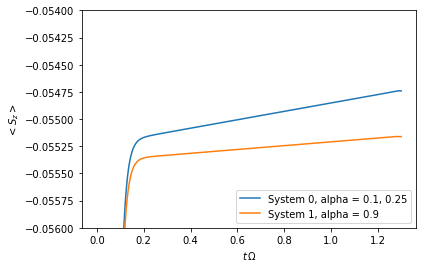

In [11]:
# plot spin expectation of systems within super-system
t_list = []
n_list = []
tsz_list = []
sz_list = []

for dynamics in dynamics_list:
    t, s_z = dynamics.expectations(0.5*sigma_z, real=True)
    tsz_list.append(t)
    sz_list.append(s_z)

alphas = [alpha_one, alpha_two]
for i in range(len(tsz_list)):
    if i == 0:
        label = f"System {i}, alpha = {alphas[i]}, {alpha_three}"
    else:
        label = f"System {i}, alpha = {alphas[i]}"
    plt.plot(tsz_list[i], sz_list[i], label=label)
    
plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_z>$')
plt.ylim(-0.056,-0.054)
plt.legend(loc='lower right')